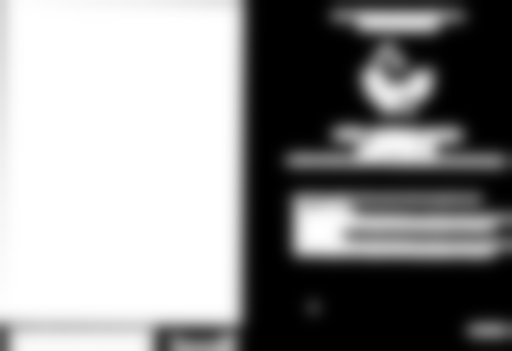

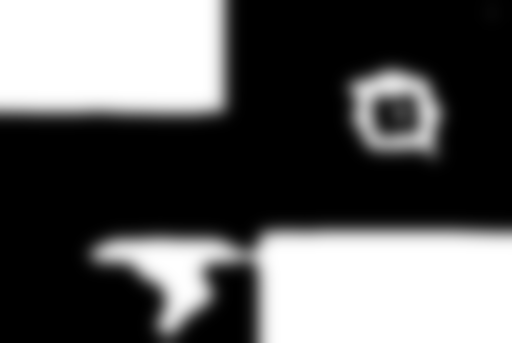

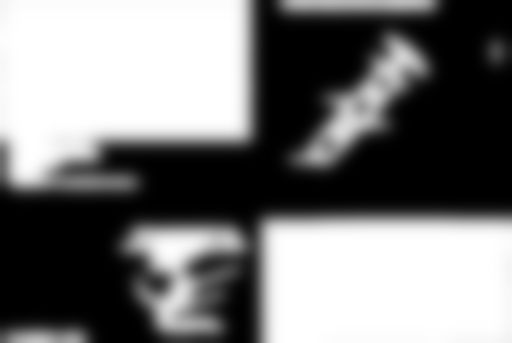

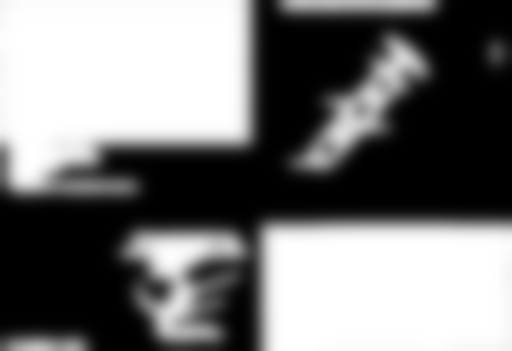

loai_2/3B8283B2-3.jpg: loai 2
0.8713835819227976 0.8939432692719945


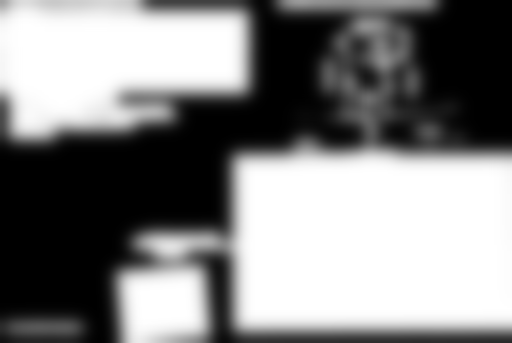

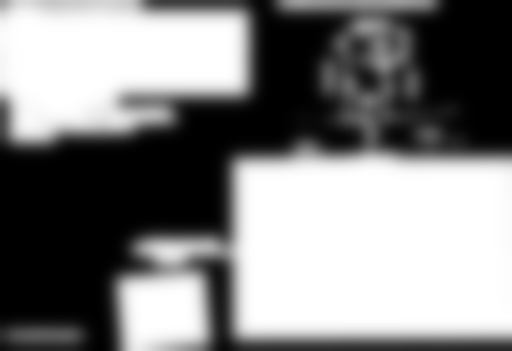

loai_2/BA686834-3.png: loai 2
0.8630107518434724 0.8847542141856742


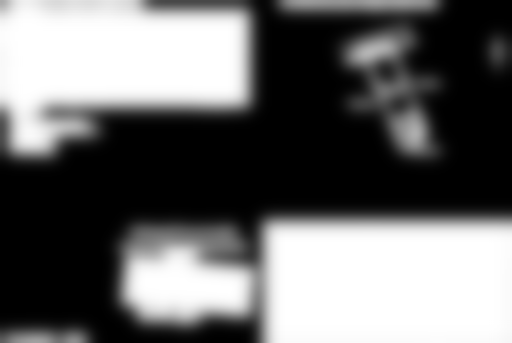

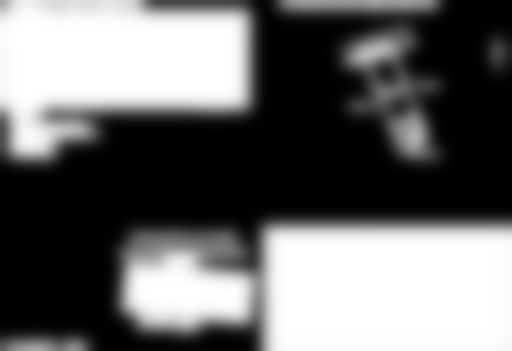

loai_2/CB944350-3.png: loai 2
0.8709731212641751 0.912164285357


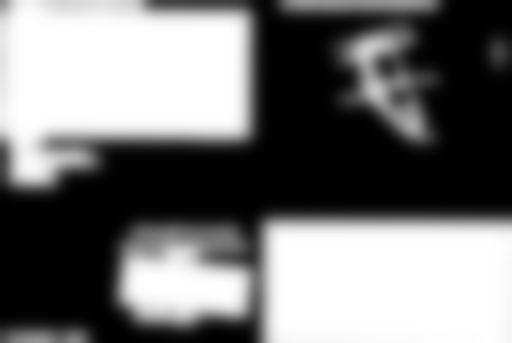

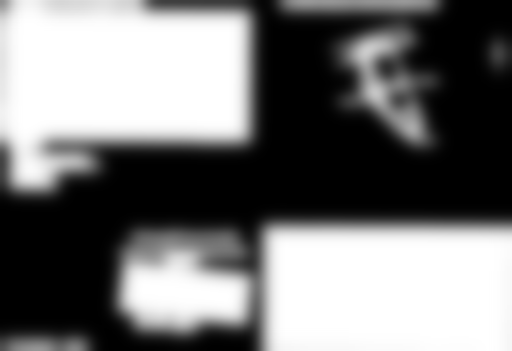

loai_2/CB944352-2.png: loai 2
0.8709510380006704 0.8976782007445836


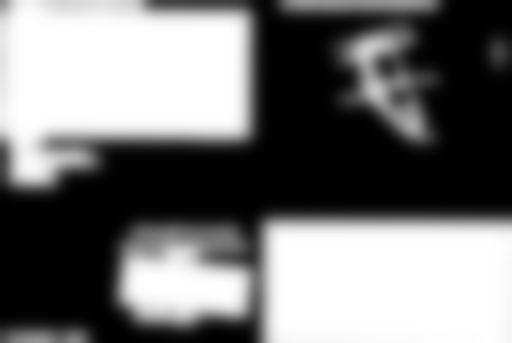

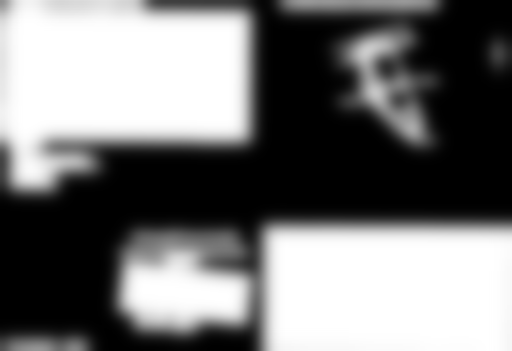

loai_2/CB944352-3.png: loai 2
0.8709510380006704 0.8976782007445836


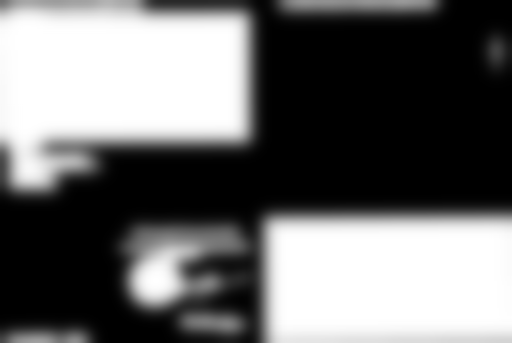

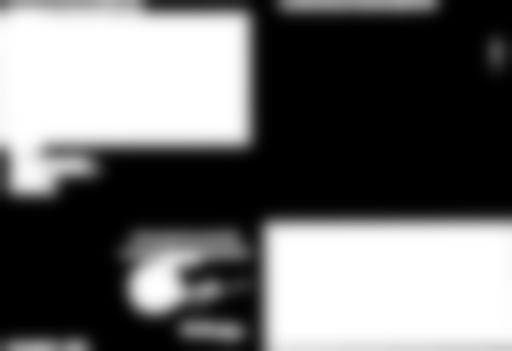

loai_2/CB944354-3.png: loai 2
0.8642468036003575 0.892683300998971


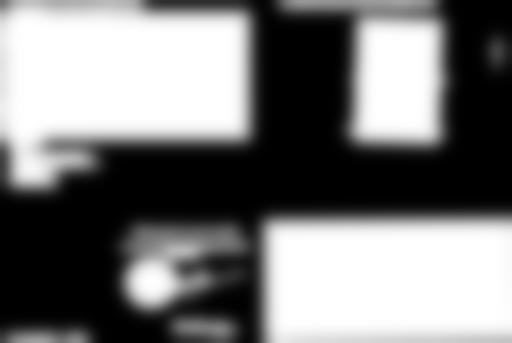

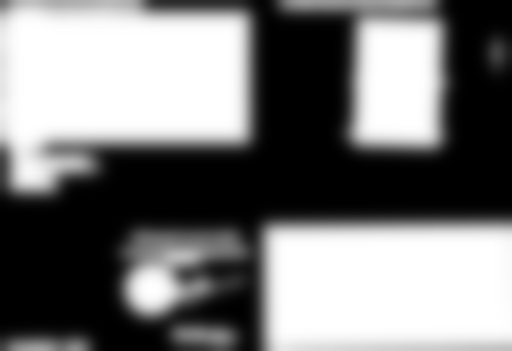

loai_2/CB944356-3.png: loai 2
0.8610580850930116 0.8899278684688161


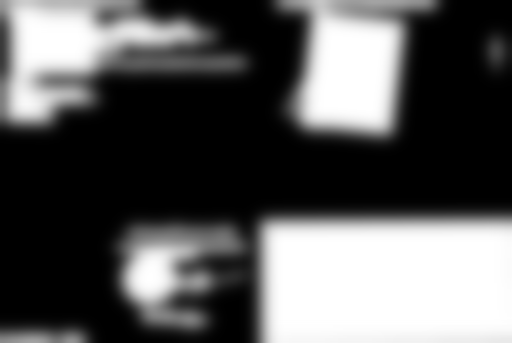

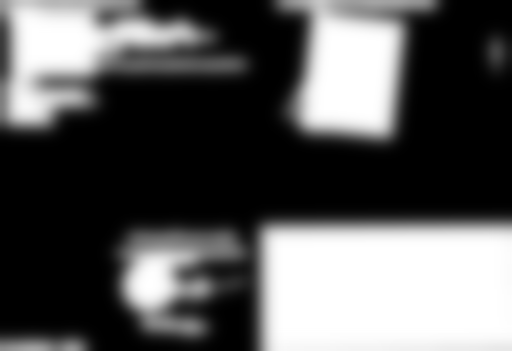

loai_2/CB944363-3.png: loai 2
0.8512586805555555 0.8929463079874806


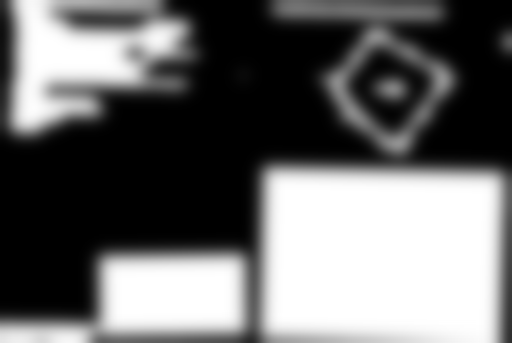

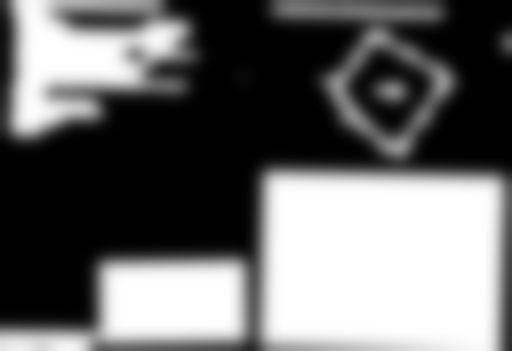

loai_2/CD573519-2.png: loai 2
0.8499238651122842 0.876991220595381


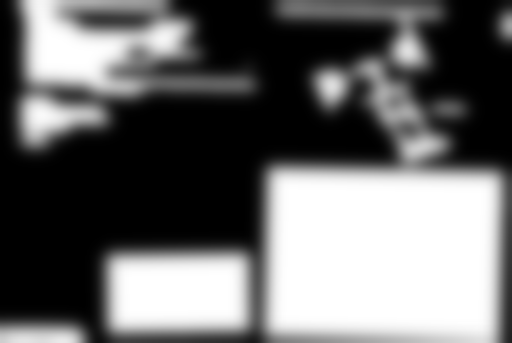

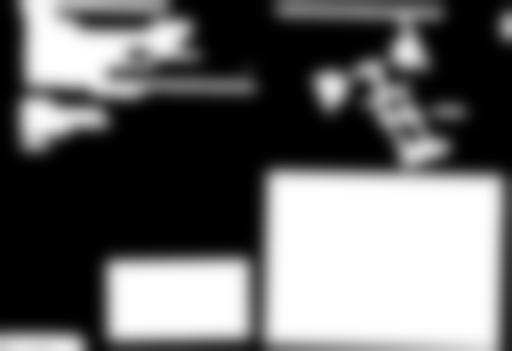

loai_2/CD573827-2.png: loai 2
0.8459444261144629 0.8664093539201395


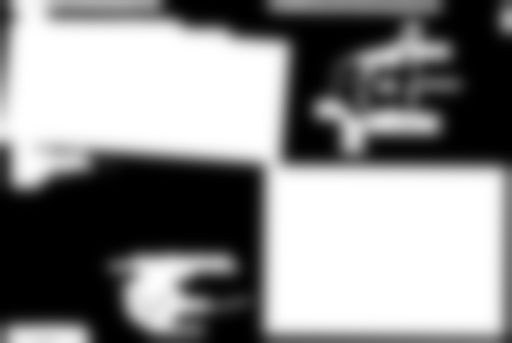

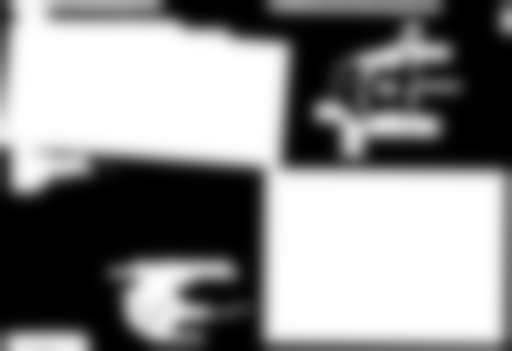

loai_2/CE428748-3.png: loai 2
0.8439305284970113 0.8645509319799348


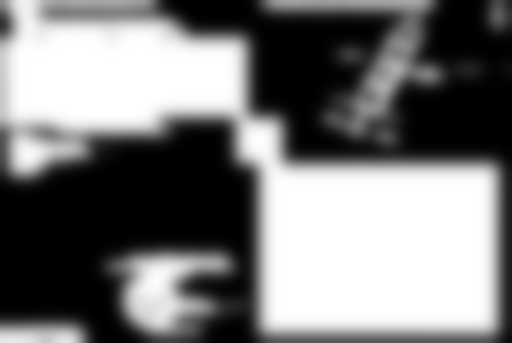

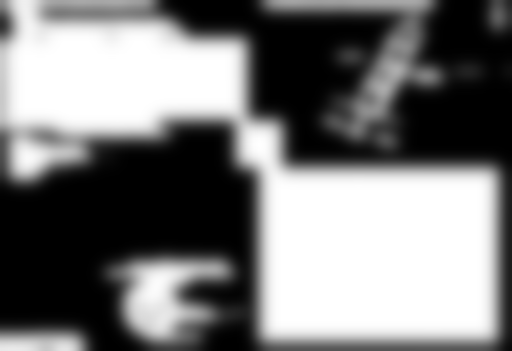

loai_2/CE428758-3.png: loai 2
0.8528110772442881 0.8723643251943635


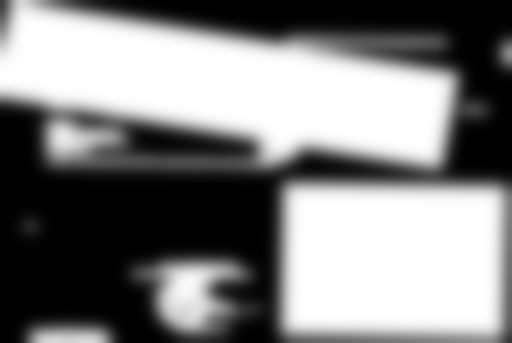

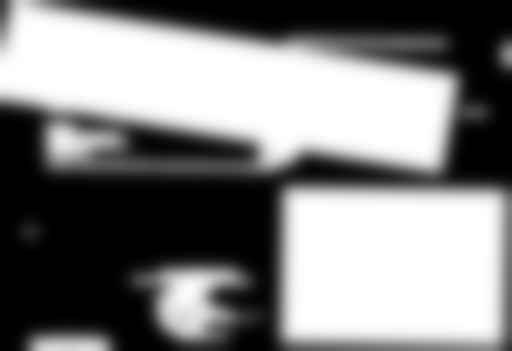

loai_2/CE428771-2.png: loai 2
0.8469222651667505 0.865294466000686


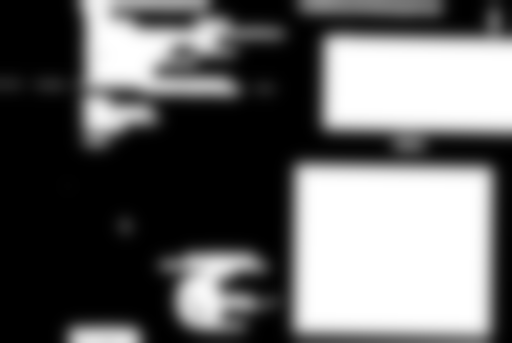

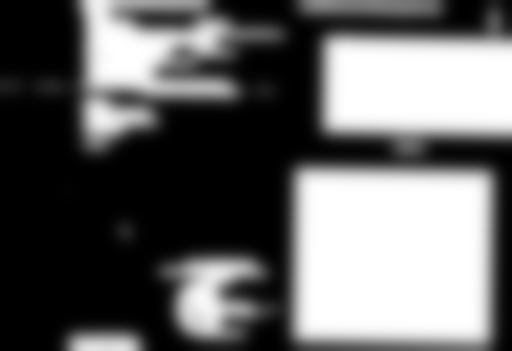

loai_2/CE428772-2.png: loai 2
0.8474226954848891 0.8657256652661065


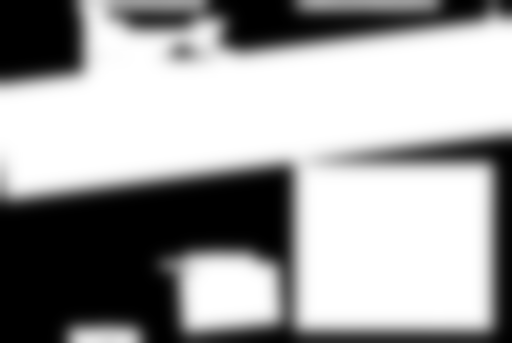

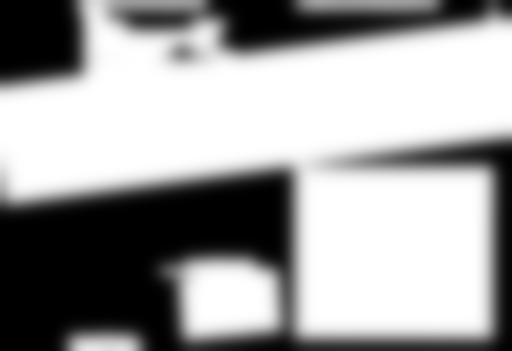

loai_2/CE428775-2.png: loai 2
0.8551235353471873 0.8689039231764134


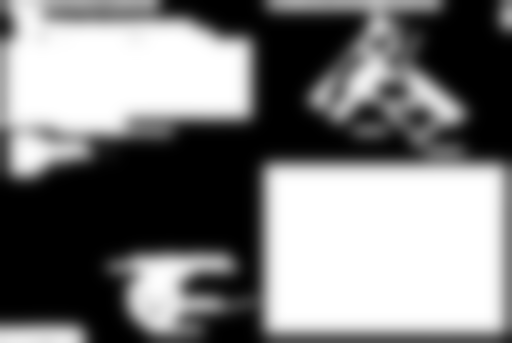

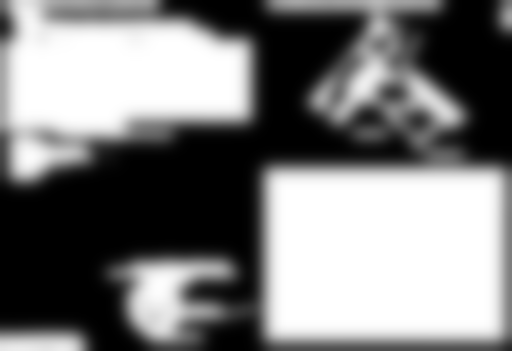

loai_2/CE428785-3.png: loai 2
0.8459276890955812 0.8668408434802493


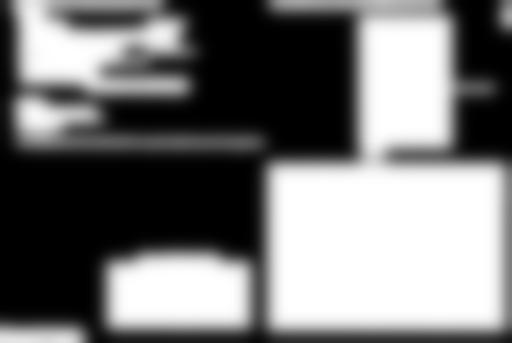

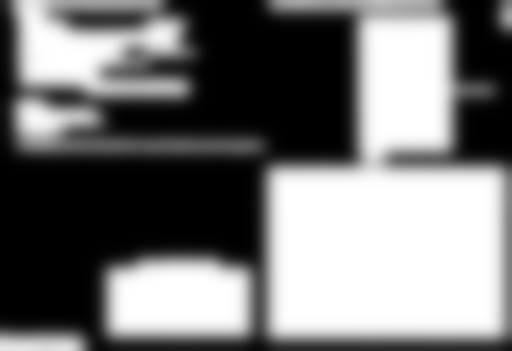

loai_2/CE428789-2.png: loai 2
0.8342656311099939 0.85671893757503


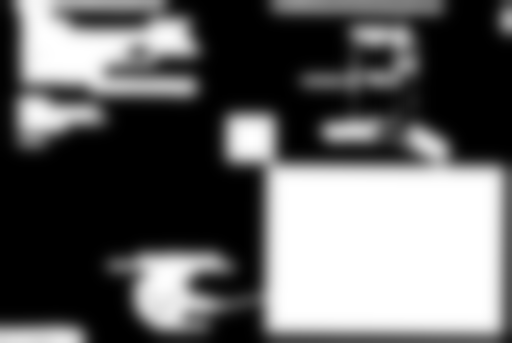

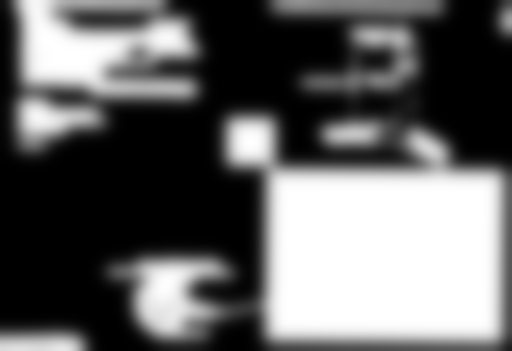

loai_2/CE428797-2.png: loai 2
0.8385319561407184 0.8620604938403933


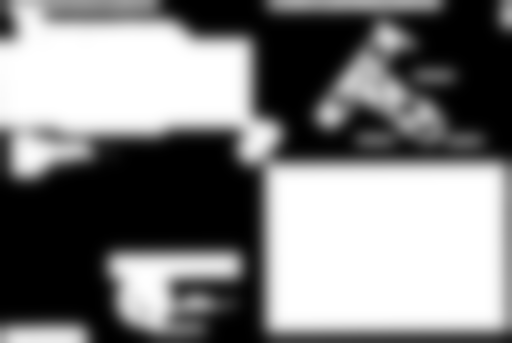

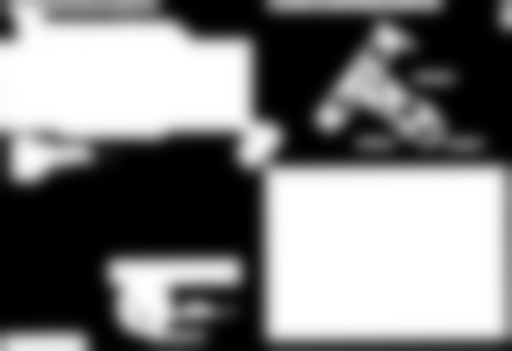

loai_2/CH105504-3.png: loai 2
0.8455320233506508 0.8639155662264906


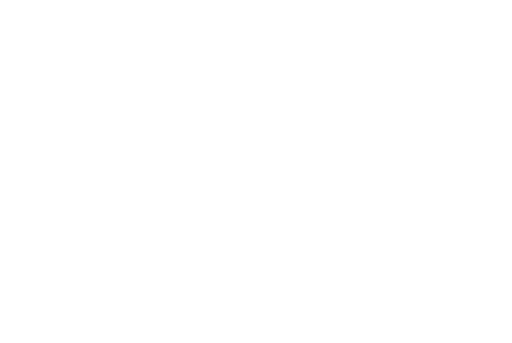

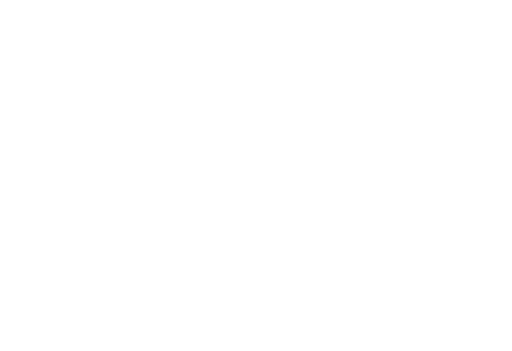

loai_2/CH105513-2.png: loai 2
0.9058568437168315 0.9421549869947979


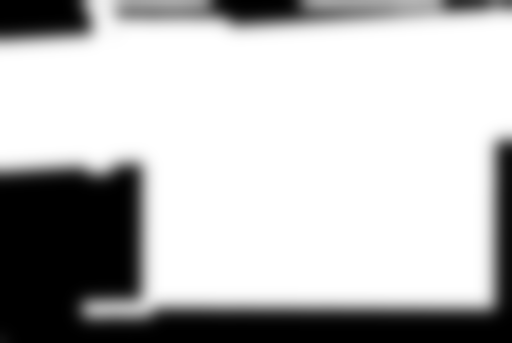

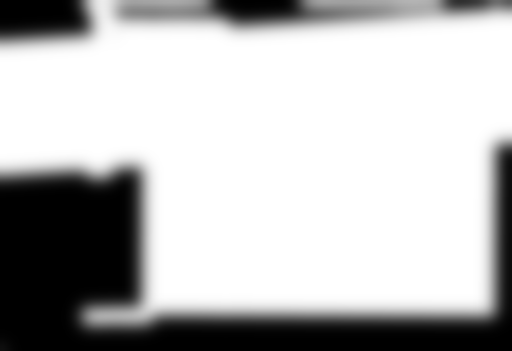

loai_2/CH105517-3.png: loai 2
0.8678066387701804 0.8936748136754702


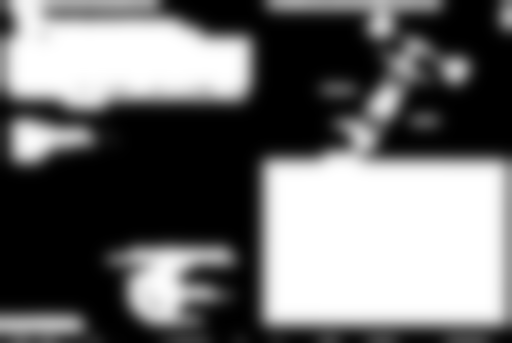

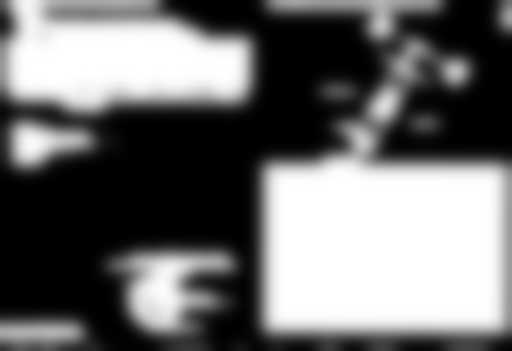

loai_2/CH105521-3.png: loai 2
0.8477600107885035 0.8717246720116618


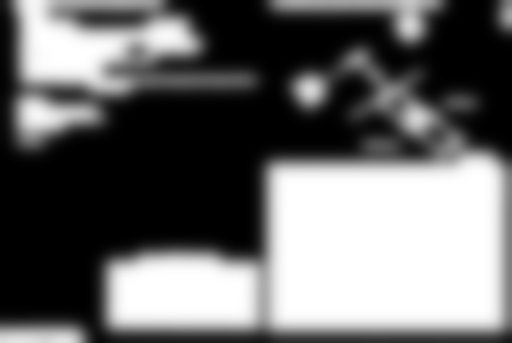

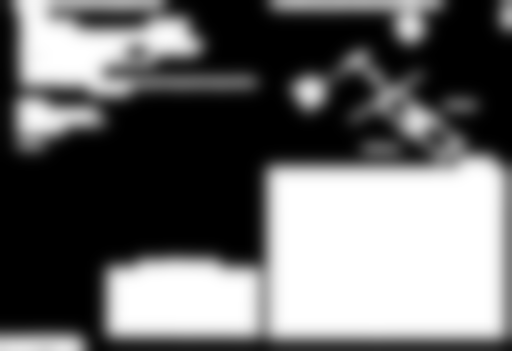

loai_2/CH105522-2.png: loai 2
0.840409622716608 0.866305629394615


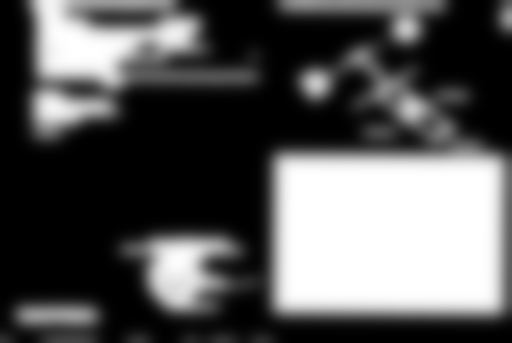

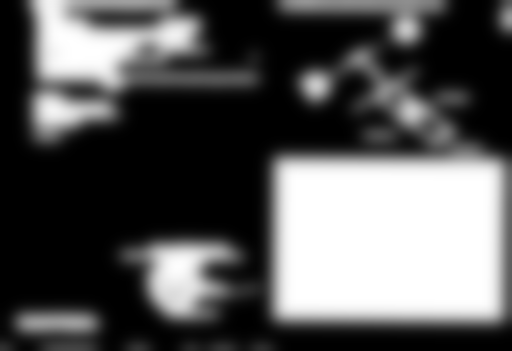

loai_2/CH105525-2.png: loai 2
0.8402797853471873 0.8739864249271136


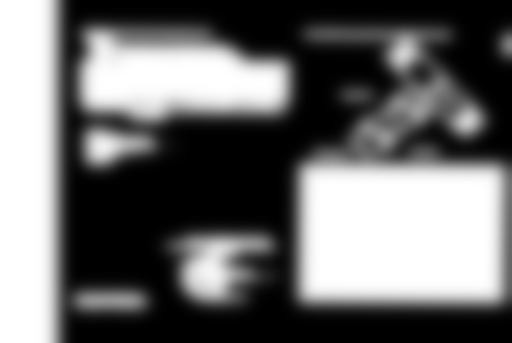

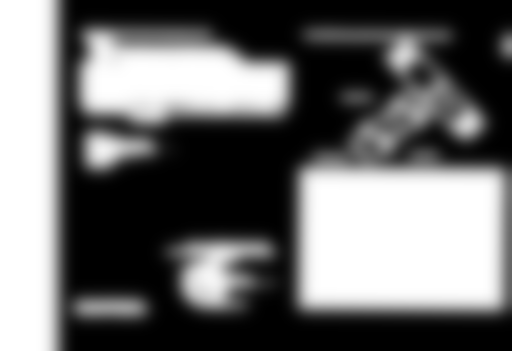

loai_2/CH105529-3.png: loai 2
0.8423703633875202 0.875409561145887


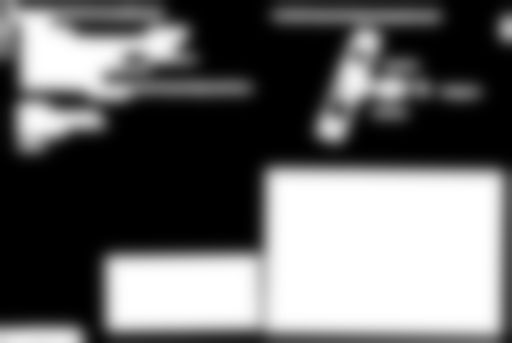

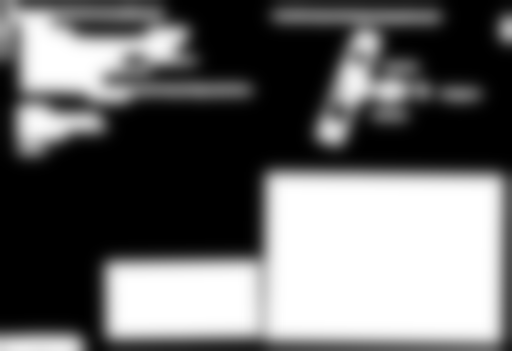

loai_2/CH105531-2.png: loai 2
0.8387058945729289 0.8611606472946322


In [1]:
import cv2
import cv2 as cv
import imutils
from imutils import contours
from imutils import perspective
import numpy as np
from PIL import Image
from PIL import ImageEnhance
from os import walk
import numpy as np
from matplotlib import pyplot as plt
import math

def inverte(img):
    return (255-img)
    
def increaseLine(img):
    edged = canny_edge_detection(img, 5, 0, 200)
    new_img = img.copy()
    linesP = cv2.HoughLinesP(edged, 1, np.pi / 180, 40, None, 40, 5)
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv2.line(new_img, (l[0], l[1]), (l[2], l[3]), (0, 0, 255), 2, cv2.LINE_AA)
    return new_img

def removeSpace(img):
    original = img.copy()
    blur = cv2.GaussianBlur(original, (25, 25), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    # Perform morph operations, first open to remove noise, then close to combine
    noise_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, noise_kernel, iterations=2)
    close_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
    close = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, close_kernel, iterations=3)
    # Find enclosing boundingbox and crop ROI
    coords = cv2.findNonZero(close)
    x,y,w,h = cv2.boundingRect(coords)
    cv2.rectangle(img, (x, y), (x + w, y + h), (0,255,12), 2)
    crop = original[y:y+h, x:x+w]
    return crop

def canny_edge_detection(img, blur_ksize=5, threshold1=100, threshold2=200):
    img_gaussian = cv2.GaussianBlur(img, (blur_ksize, blur_ksize), 0)
    img_canny = cv2.Canny(img_gaussian, threshold1, threshold2)
    return img_canny

def loadImage(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def listFile(path):
    return next(walk(path), (None, None, []))[2]  # [] if no file

def calSimilar(tem, inp):
    width, height = tem.shape
    max_diff = width * height * 255
    tem_a = np.array(tem).astype('int8')
    inp_a = np.array(inp).astype('int8')
    score = np.sum(np.absolute(inp_a - tem_a))
    return 1 - score/max_diff

def addPadding(img, padding):
    img_height, img_width = img.shape
    img = img[padding:img_height-padding, padding:img_width-padding]
    img = cv2.copyMakeBorder(img, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value = [0, 0, 0])
    return img

def preFindContours(img):
    img = increaseLine(img) # keep line
    img = cv2.GaussianBlur(img, (9, 9), 0)
    
    # REMOVE TRASH
    # dilate
    img = canny_edge_detection(img, 1, 50, 100)
    img = cv2.dilate(img, None, iterations = 5)
    # add padding
    img = addPadding(img, 15)
    return img
    
def findContours(in_img):
    img = in_img.copy()
    img = preFindContours(img)
    # FIND CONTOURS
    # find contours in the edge map
    cnts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    # sort the contours from left-to-right
    # (cnts, _) = contours.sort_contours(cnts)
    return cnts

def fillContours(img, cnts):
    # loop over the contours individually
    for (i, c) in enumerate(cnts):
        # if the contour is not sufficiently large, ignore it
        if cv2.contourArea(c) < 20000:
            continue
        # compute the rotated bounding box of the contour, then
        # draw the contours
        box = cv2.minAreaRect(c)
        if (box[2] > 10 and box[2] < 80) or (box[1][0] < 100 or box[1][1] < 100):
            continue
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        cv2.drawContours(img, [box], -1, (255, 255, 255), cv2.FILLED)
    return img

def removeWhiteDot(img, size):
    blur = cv2.GaussianBlur(img, (size, size), 0)
    return cv2.threshold(blur, 100, 255, cv2.THRESH_BINARY)[1]

def run(path = "image1.png", width = None, height = None):
    img = loadImage(path)
    cnts = findContours(img)
    img = increaseLine(img) # keep line
    img = cv2.GaussianBlur(img, (9, 9), 0)
    edged = canny_edge_detection(img, 1, 50, 100)
    edged = cv2.dilate(edged, None, iterations = 5)
    edged = addPadding(edged, 15)
    edged = removeWhiteDot(edged, 101)
    edged = fillContours(edged, cnts)
    
#     edged = canny_edge_detection(img, 1, 50, 100)
#     edged = cv2.dilate(edged, None, iterations = 8)
#     edged = removeWhiteDot(edged)
    
    # remove outline noise
    edged = addPadding(edged, 50)
    edged = inverte(edged)
    edged = removeSpace(edged)
    edged = inverte(edged)
    
    if width != None and height != None:
        edged = cv2.resize(edged, (height, width), interpolation = cv2.INTER_AREA)
    elif width != None:
        img_height, img_width = edged.shape
        edged = cv2.resize(edged, (width, int((width/img_width)*img_height)), interpolation = cv2.INTER_AREA)
    edged = cv2.GaussianBlur(edged, (51, 51), 0)
    display(Image.fromarray(edged))
    return edged
    
width = 512

tem1 = run(path = "image4.png", width = width)
width1, height1 = tem1.shape
tem2 = run(path = "image1.png", width = width)
width2, height2 = tem2.shape

path1 = "loai_2/"

for f in listFile(path1):
    inp = run(path = path1 + f, width = width2, height = height2)
    res2 = calSimilar(tem2, inp)
    inp = run(path = path1 + f, width = width1, height = height1)
    res1 = calSimilar(tem1, inp)
    if res1 > res2:
        print(path1 + f + ": loai 1")
    elif res1 == res2:
        print(path1 + f + ": loai 1, 2")
    else:
        print(path1 + f + ": loai 2")
    print(res1, res2)
